In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
import pandas as pd
import imageio

from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

from imgaug import augmenters as iaa
from PIL import Image
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import matplotlib.pyplot as plt

import cv2
from pathlib import Path
from torchvision import transforms
from torchvision.io import read_image
from torchvision.utils import save_image


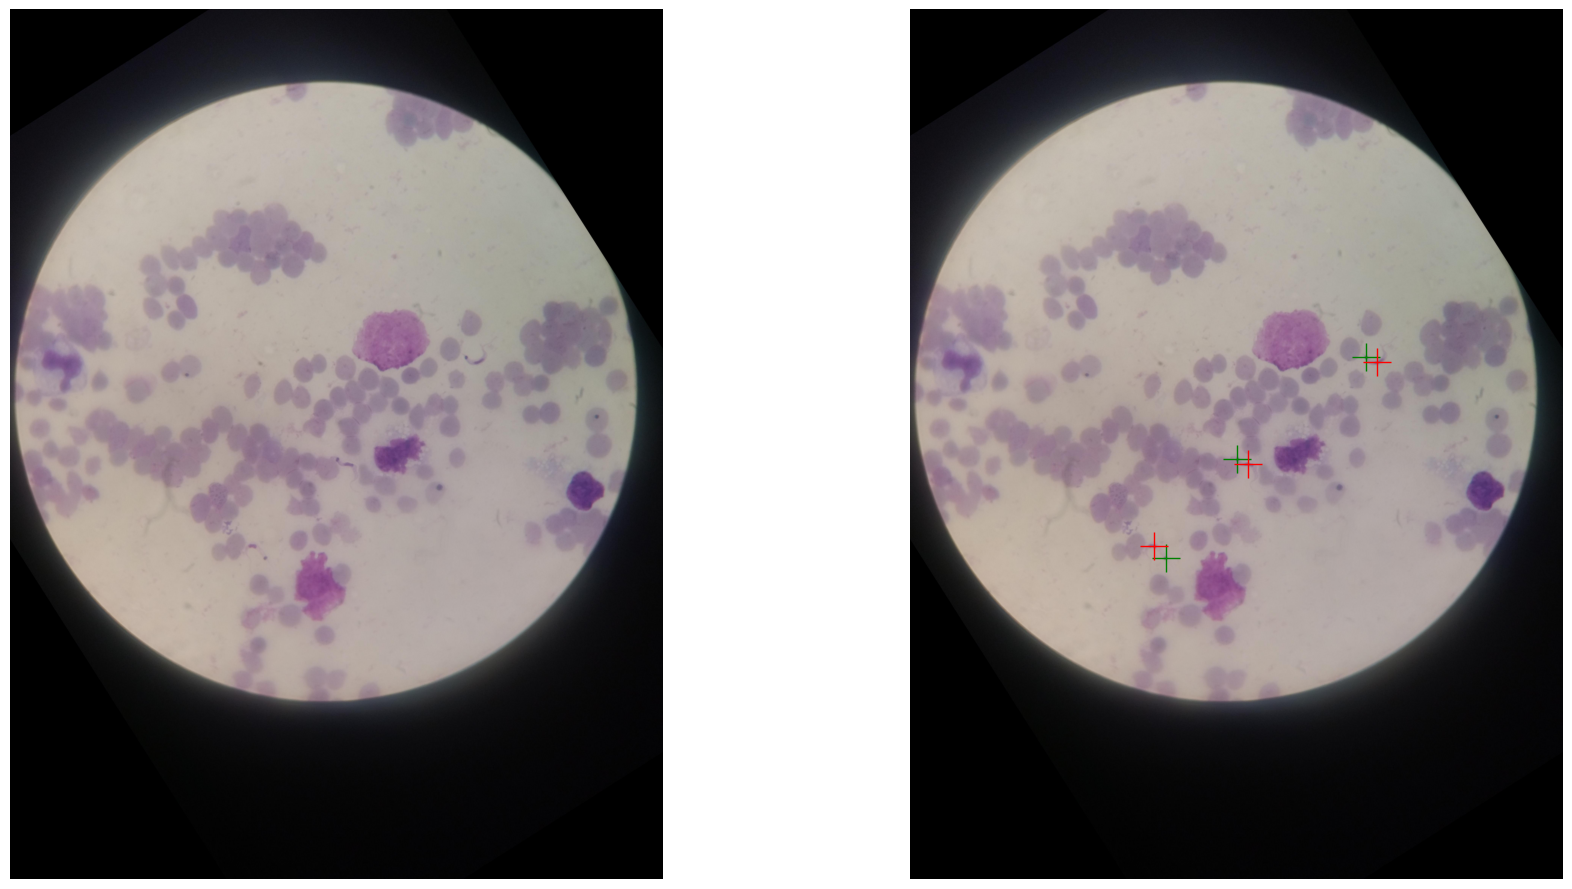

In [6]:
###Mark parasite
output_folder = '/Users/clee/Documents/Nolan_Lab/chagas/trypoastigote_images/augment'

abacadaba = 'augmented_field0001'

image_file = f'{abacadaba}.jpg_1.jpg' 
image_path = os.path.join(output_folder, image_file)
image = Image.open(image_path)
image_array = np.array(image)

annotations_file = f'{abacadaba}_1.csv'  
annotations_path = os.path.join(output_folder, annotations_file)
augmented_annotations_df = pd.read_csv(annotations_path)

fig, axs = plt.subplots(1, 2, figsize=(20, 9))

axs[0].imshow(image_array)
axs[0].axis('off')
axs[1].imshow(image_array)
axs[1].axis('off')

for _, row in augmented_annotations_df.iterrows():
    x = row['x']
    y = row['y']
    structure = row['structure']
    
    if structure in ['NUCLEUS', 'NUCLEUS_CELL_BODY']:
        axs[1].plot(x, y, 'r+', markersize=20, label='NUCLEUS')
    elif structure == 'KINETOPLAST':
        axs[1].plot(x, y, 'g+', markersize=20, label='KINETOPLAST')

        

plt.tight_layout()
plt.show()

In [16]:
###Crop 'perfect' microscope circle
input_directory = '/Users/clee/Documents/Nolan_Lab/chagas/data/negative_images'
output_directory = '/Users/clee/Documents/Nolan_Lab/chagas/augmented_images'
failed_log_path = '/Users/clee/Documents/Nolan_Lab/chagas/failed_images.txt'

failed_images = []

for filename in os.listdir(input_directory):
    if filename.lower().endswith(('.png')):  
        try:
            image_path = os.path.join(input_directory, filename)
            image = cv2.imread(image_path)

            image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_blurred = cv2.medianBlur(gray, 5)

            detected_circles = cv2.HoughCircles(
                gray_blurred,
                cv2.HOUGH_GRADIENT, dp=1, minDist=gray.shape[0]/2,
                param1=50, param2=40, minRadius=gray.shape[0]//3, maxRadius=gray.shape[0]//2
            )

            if detected_circles is not None:
                detected_circles = np.uint16(np.around(detected_circles))
                x, y, r = detected_circles[0][0]
                mask = np.zeros_like(gray)
                cv2.circle(mask, (x, y), r, (255, 255, 255), -1)
                circular_image = cv2.bitwise_and(image, image, mask=mask)
                x, y, w, h = x - r, y - r, 2 * r, 2 * r
                cropped_image = circular_image[y:y+h, x:x+w]

                output_path = os.path.join(output_directory, filename)
                cv2.imwrite(output_path, cropped_image)
            else:
                failed_images.append(filename)

        except Exception as e:
            print(f"Failed to process {filename}: {e}")
            failed_images.append(filename)

with open(failed_log_path, 'w') as f:
    for item in failed_images:
        f.write("%s\n" % item)

print(f"Processing complete. Failed images logged to {failed_log_path}.")


/var/folders/1f/_308mdp92hd4dnhtd2p2jgk40000gn/T/ipykernel_1885/4227765616.py:41: RuntimeWarning: overflow encountered in ushort_scalars
  x, y, w, h = x - r, y - r, 2 * r, 2 * r


Failed to process empty_field0587.png: OpenCV(4.7.0) /Users/xperience/GHA-OCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

Failed to process empty_field0236.png: OpenCV(4.7.0) /Users/xperience/GHA-OCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

Failed to process empty_field0008.png: OpenCV(4.7.0) /Users/xperience/GHA-OCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

Failed to process empty_field0020.png: OpenCV(4.7.0) /Users/xperience/GHA-OCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

Failed to process empty_field0197.png: OpenCV(4.7.0) /Users/xper

In [ ]:
###Augment images
def apply_circular_mask(image):
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
    radius = min(center_x, center_y)

    Y, X = np.ogrid[:image.shape[0], :image.shape[1]]
    dist_from_center = np.sqrt((X - center_x)**2 + (Y-center_y)**2)
    mask = dist_from_center <= radius

    image[~mask] = 0
    return image

seq = iaa.Sequential([
    iaa.Fliplr(0.5),  
    iaa.Flipud(0.2),  
    iaa.Affine(
        rotate=(-160, 160),  
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},  
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, 
        shear=(-5, 5) 
    ),
    iaa.Multiply((0.5, 1.4)), 
    iaa.LinearContrast((0.5, 1.4)), 
    iaa.GaussianBlur(sigma=(0, 0.5)), 
], random_order=True)  

#image_path = '/Users/clee/Documents/Nolan_Lab/chagas/data_circle/positive_images/field0194.png'
input_directory = '/Users/clee/Documents/Nolan_Lab/chagas/data_circle/positive_images'
output_directory = '/Users/clee/Documents/Nolan_Lab/chagas/augmented_images'

for filename in os.listdir(input_directory):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')): 
        image_path = os.path.join(input_directory, filename)
        image = imageio.imread(image_path)
        
        images_aug = [seq(image=image) for _ in range(10)]          
        images_aug = [apply_circular_mask(img) for img in images_aug]
        
        for idx, image_aug in enumerate(images_aug):
            augmented_image_path = os.path.join(output_directory, f"{os.path.splitext(filename)[0]}_augmented_{idx}.png")
            imageio.imwrite(augmented_image_path, image_aug)